# Введение

Вас перевели в отдел инновационной разработки рекомендательных систем. Ваш работадель хочет увеличить средний чек продаж. После короткого изучения статей вы поняли, что ключом к успеху будет качественные рекомендации на сайте. Чем лучше вы сможете рекомендовать товар пользователю, тем чаще он будет добавлять товары в корзину. Простая логика, если пользователю нравится товар, он его добавляет в корзину -> средний чек растёт. Мы нашли золото!

Датасет

У вас будет история оценок пользователя вместе с его обзором. Вы можете использовать текст рецензии в качестве дополнительной информации. Все оценки пользователей нормированы для бинарной классификации, если человек поставил оценку продукту больше 3 (не включительно), то мы считаем, что продукт ему понравился, если меньше 4, то продукт не понравился.

Метрики

В качестве метрики для оценки ваших рекомендаций используется **RocAuc**.

Условия соревнования

Данное соревнование является бессрочным и доступно для всех потоков. Срок выполнения соревнования устанавливаеться индивидуально в каждом потоке. Тестовая выборка представлена в ЛидерБорде целиком, поэтому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку). В данном соревновании вам ненужны дополнительные внешние данные. Запрещается их использовать Разрешено использовать любые ML алгоритмы и библиотеки.

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, Input, BatchNormalization
from keras.optimizers import Adam
from keras import metrics
from keras.utils.vis_utils import plot_model

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.
import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json


**test.csv** - набор данных, для которого необходимо сделать предсказания. У каждого набора **userid, itemid** есть свой id, для которого вы должны сделать предсказание.

* **overall** - рейтинг, который поставил пользователь
* **verified** - был ли отзыв верифицирован
* **reviewTime** - когда был отзыв написан
* **reviewerName** - имя пользователя
* **reviewText** - текст отзыва
* **summary** - сжатый отзыв
* **unixReviewTime** - дата отзыва в формате unix
* **vote** - количество голосований за отзыв
* **style** - метаданные
* **image** - изображение продукта
* **userid** - id пользователя
* **itemid** - id товара
* **id** - id для предсказания

In [ ]:
test.info()

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Pandas       :', pd.__version__)
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)

# Установка библиотек, инициализация вспомогательных функций и загрузка данных

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve

import scipy.sparse as sparse
from scipy.sparse import csr_matrix, csc_matrix 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import itertools


In [ ]:
'''
# install pandas-profiling
!pip install pandas-profiling
from pandas_profiling import ProfileReport
'''

In [44]:
RANDOM_STATE = 32

# типовые параметры для модели lightFM
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

# Вспомогательные функции
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'LightFM')
    plt.title('ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
def get_boxplot(column, ds, ord):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=ord, 
                data=ds.loc[ds.loc[:, column].isin(ds.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
def rmse(y_true, y_pred):
    return np.sqrt(np.square(y_pred-y_true).sum()/len(y_true))
    
def feature_init():
    # Составим списки категориальных, бинарных и численных признаков
    cat_cols = ['reviewerName', 'reviewText', 'summary', 'style', 'image']
    bin_cols =['verified']
    num_cols =['overall', 'unixReviewTime', 'rating', 'userid', 'itemid'] # 'vote',
    
    return cat_cols, bin_cols, num_cols 

def put_submission(preds):
    normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
    submission['rating'] = normalized_preds
    submission.to_csv('./submission_log.csv', index=False)
    return submission

def create_review_tone(data):
    # Creating new features.
    data['good_review'] = 0
    data['bad_review'] = 0

    # Creating new features.
    ind = 0
    for review in data['reviewText']:
        if pd.isna(review):
            ind += 1
            break
        for word in good_words_list:
            if word in review:
                data.at[ind,'good_review'] = 1
                break
        for word in bad_words_list:
            if word in review:
                data.at[ind,'bad_review'] = 1
                break   
        ind += 1
        
def create_summary_tone(data):    
    data['good_summary'] = 0
    data['bad_summary'] = 0

    ind = 0
    for review in data['summary']:
        if pd.isna(review):
            ind += 1
            break
        for word in good_words_list:
            if word in review:
                data.at[ind,'good_summary'] = 1
                break
        for word in bad_words_list:
            if word in review:
                data.at[ind,'bad_summary'] = 1
                break   
        ind += 1
        
def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1, user_features=np.array([]), item_features =np.array([])):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        if (item_features.getnnz() == 0) & (user_features.getnnz() == 0):
            model.fit(train, epochs=num_epochs, num_threads=num_threads)
        elif (item_features.getnnz() > 0) & (user_features.getnnz() == 0):
            model.fit(train, epochs=num_epochs, num_threads=num_threads, item_features=item_features)
        elif (item_features.getnnz() == 0) & (user_features.getnnz() > 0):
            model.fit(train, epochs=num_epochs, num_threads=num_threads, user_features=user_features)
        else:
            model.fit(train, epochs=num_epochs, num_threads=num_threads, user_features=user_features, item_features=item_features)
        
        score = auc_score(model, test_interactions=test, train_interactions=train, num_threads=num_threads, check_intersections=False).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [17]:
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv', low_memory=False)
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv', low_memory=False)
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

# Создание наивной модели

In [ ]:
'''
train_data, test_data = train_test_split(train,random_state=RANDOM_STATE, shuffle=True)
train_data.info()
'''

In [ ]:
'''
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))
'''              

In [ ]:
'''
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)
'''

In [ ]:
'''
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)
'''

In [ ]:
# rmse(test_data['rating'], preds)

In [ ]:
#  show_roc_curve(test_data.rating, preds)

In [ ]:
# sklearn.metrics.roc_auc_score(test_data.rating,preds)


In [ ]:
# rmse(test_data['rating'], preds)

## Submission

In [ ]:
# preds = model.predict(test.userid.values,
#                      test.itemid.values)
# put_submission(preds)

submission roc_auc 0.74475

# EDA

In [ ]:
train.info()

In [ ]:
train.sample()

In [ ]:
# ProfileReport(train, title="EDA")

Результаты предварительного EDA
* в данных много дублей
* в колонках **revierName, reviewText, vote, style, image** много пропусков
* поле **unixReviewTime** можно использовать для feature engineerig

Посмотрим на сбалансированность целевой переменной **rating**

In [ ]:
ax = sns.countplot(x="rating", data=train)

In [ ]:
'''
# сбалансируем целевую переменную с помощью функции библиотеки imblearn
from imblearn.over_sampling import SMOTE

cat_cols, bin_cols, num_cols = feature_init()

y = train.rating
X = train[num_cols] 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, shuffle=True)

sm = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = sm.fit_sample(X_train, y_train)
'''

In [ ]:
# ax = sns.countplot(x="rating", data=X_train)

In [ ]:
'''
ratings_coo = sparse.coo_matrix((X_train['rating'].astype(int),
                                 (X_train['userid'],
                                  X_train['itemid'])))
'''                                  

In [ ]:
'''
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)
'''

In [ ]:
'''
preds = model.predict(X_test.userid.values,
                      X_test.itemid.values)
'''

In [ ]:
# show_roc_curve(X_test.rating, preds)

Метрика стала хуже. Можно попытаться преобразовать категориальные переменные в цифру.

# Embedding

In [ ]:
'''
# user_feature
train['user_rating'] = train['overall'].apply(lambda x: 1 if x > 3 else 0)
train['verified'] = train['verified'].astype(int)

train_data, test_data = train_test_split(train,random_state=RANDOM_STATE, shuffle=True)

ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

total_users = max(train_data['userid'].max(), test_data['userid'].max()) + 1
identity_matrix = sparse.identity(total_users)
user_features = sparse.coo_matrix(identity_matrix, train_data[['user_rating', 'verified']])

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS,
                  user_features=user_features, 
                  num_threads=NUM_THREADS)

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
                    user_features=user_features)

show_roc_curve(test_data.rating, preds)
'''

In [ ]:
# rmse(test_data['rating'], preds)

In [ ]:
'''
# submission

total_users = max(train_data['userid'].max(), test_data['userid'].max()) + 1
identity_matrix = sparse.identity(total_users)
user_features = sparse.coo_matrix(identity_matrix, train_data[['user_rating', 'verified']])
 
preds = model.predict(test.userid.values,
                      test.itemid.values,
                    user_features=user_features)
put_submission(preds)
'''

Получили улучшение по отношению к наивной модели 0.74522

## Используем данные из дополнительного файла

In [ ]:
'''
# Построчно прочитаем json с метаданными и положим результат в датасет "meta"
with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)
'''

In [ ]:
# data = pd.merge(train, meta, on='asin')

In [ ]:
# data = pd.DataFrame(data[['itemid', 'userid', 'rank', 'price', 'rating']])

In [ ]:
'''
data['price'] = data['price'].apply(lambda x: 0.0 if pd.isna(x) else float(eval(x.replace('$', ''))))
data['rank'] = data['rank'].apply(lambda x: 0.0 if pd.isna(x) else float(re.search('\d+,?\d*', str(x))[0].replace(',', '')))
'''

In [ ]:
# rank, price item_feature
'''
train_data, test_data = train_test_split(data,random_state=RANDOM_STATE, shuffle=True)

ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1
identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['rank']])

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS,
                  item_features=item_features, 
                  num_threads=NUM_THREADS)

item_features = csr_matrix(test_data[['rank', 'price']]) 
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
                    item_features=item_features)
# оцениваем результат
show_roc_curve(test_data.rating, preds)     
'''

roc_auc = 0.501. Практически угадывание. 

In [ ]:
# submission
# item_features = csr_matrix(train_data[['user_rating']]) 
# preds = model.predict(test.userid.values,
#                      test.itemid.values,
#                    item_features=user_features)
# put_submission(preds)

Результат еще хуже. Чем больше фичей, тем хуже.
Попробуем использовать текстовый файл.

# используем reviewText

In [ ]:
good_words_list = [
    "best",
    "good",
    "great",
    "love",
    "delicious",
    "nice",
    "favorite",
    "tasty",
    "perfect",
    "excellent",
    "wonderful",
    "enjoy",
    "yummy",
    "happy",
    "loves",
    "loved",
    "amazing",
    "awesome",
    "yum",
    "enjoyed",
    "fantastic",
    "perfectly",
    "wow",
    "lovely",
    "beautiful",
    "terrific",
    "enjoyable"
]

bad_words_list = [
    "awful",
    "bad",
    "disappointed",
    "unfortunate",
    "waste",
    "weird",
    "difficult",
    "terrible",
    "horrible",
    "complaint",
    "gross",
    "worst",
    "strange",
    "fake",
    "disappointing",
    "complaints",
    "poor",
    "sucks"
]

In [ ]:
'''
create_review_tone(train)
create_summary_tone(train)
train_data, test_data = train_test_split(train,random_state=RANDOM_STATE, shuffle=True)

ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1
identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['good_review', 'bad_review', 'good_summary', 'bad_summary']])

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS,
                  item_features=item_features, 
                  num_threads=NUM_THREADS)

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
                    item_features=item_features)

show_roc_curve(test_data.rating, preds)
'''

In [ ]:
# rmse(test_data['rating'], preds)

In [ ]:
# submission
'''
total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1
identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['good_review', 'bad_review', 'good_summary', 'bad_summary']])
 
preds = model.predict(test.userid.values,
                      test.itemid.values,
                    item_features=item_features)
put_submission(preds)
'''

Получили улучшение по отношению к наивной модели 0.74522

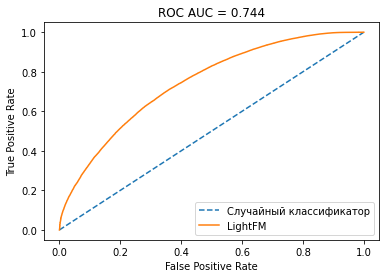

In [50]:
# Совместное использование user & item emdeddings
train['user_rating'] = train['overall'].apply(lambda x: 1 if x > 3 else 0)
train['verified'] = train['verified'].astype(int)
create_review_tone(train)
create_summary_tone(train)

train_data, test_data = train_test_split(train,random_state=RANDOM_STATE, shuffle=True)

ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

total_users = max(train_data['userid'].max(), test_data['userid'].max()) + 1
total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1

# user_feature
identity_matrix = sparse.identity(total_users)
user_features = sparse.coo_matrix(identity_matrix, train_data[['user_rating', 'verified']])

#item_feature
identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['good_review', 'bad_review', 'good_summary', 'bad_summary']])

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS,
                  user_features=user_features,
                  item_features=item_features,
                  num_threads=NUM_THREADS)

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
                    user_features=user_features,
                     item_features=item_features)

show_roc_curve(test_data.rating, preds)

In [51]:
rmse(test_data['rating'], preds)

2.1259197133679777

In [52]:
# submission

total_users = max(train_data['userid'].max(), test_data['userid'].max()) + 1
total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1

identity_matrix = sparse.identity(total_users)
user_features = sparse.coo_matrix(identity_matrix, train_data[['user_rating', 'verified']])

identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['good_review', 'bad_review', 'good_summary', 'bad_summary']])
 
preds = model.predict(test.userid.values,
                      test.itemid.values,
                    user_features=user_features,
                     item_features=item_features)
put_submission(preds)

,Id,rating
0,0,0.518357
1,1,0.509850
2,2,0.486815
3,3,0.481688
4,4,0.505698
...,...,...
285960,285960,0.519593
285961,285961,0.397383
285962,285962,0.488438
285963,285963,0.518936


Совместное использование user&item feature немного улучшило roc auc 0.74530



## Hyperparameters tuning

### without features

In [18]:
'''
# Настройка гиперпараметров модели
train_coo = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'])))
train_data, test_data = random_train_test_split(train_coo)

(score, hyperparams, model) = max(random_search(train_data, test_data, num_threads=2), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))
'''

Best score 0.7994440793991089 at {'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.0077137798478582684, 'item_alpha': 1.9520127197867578e-08, 'user_alpha': 1.3974487532642269e-08, 'max_sampled': 10, 'num_epochs': 15}


In [19]:
'''
EPOCHS = hyperparams['num_epochs']
del hyperparams['num_epochs']
hyperparams
'''

{'no_components': 49,
 'learning_schedule': 'adagrad',
 'loss': 'warp-kos',
 'learning_rate': 0.0077137798478582684,
 'item_alpha': 1.9520127197867578e-08,
 'user_alpha': 1.3974487532642269e-08,
 'max_sampled': 10}

submission roc_auc 0.55700

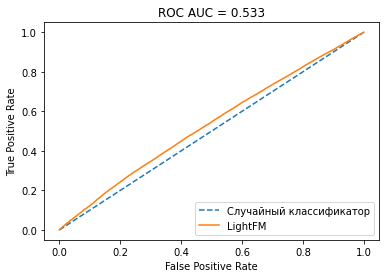

In [22]:
'''
train_data, test_data = train_test_split(train,random_state=RANDOM_STATE, shuffle=True)
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))


model = LightFM(**hyperparams)
# model.fit(train, epochs=num_epochs, num_threads=num_threads)
model = model.fit(ratings_coo, epochs=EPOCHS,
                  num_threads=NUM_THREADS 
)

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
)

show_roc_curve(test_data.rating, preds)
'''

In [23]:
'''
# submission

preds = model.predict(test.userid.values,
                      test.itemid.values,
)
put_submission(preds)
'''

,Id,rating
0,0,0.375183
1,1,0.368232
2,2,0.295194
3,3,0.389579
4,4,0.557236
...,...,...
285960,285960,0.355495
285961,285961,0.520644
285962,285962,0.475594
285963,285963,0.401624


submission roc_auc 0.53664

### with features

In [45]:
'''
# подготовка user & item emdeddings
train['user_rating'] = train['overall'].apply(lambda x: 1 if x > 3 else 0)
train['verified'] = train['verified'].astype(int)
create_review_tone(train)
create_summary_tone(train)

train_data, test_data = train_test_split(train,random_state=RANDOM_STATE, shuffle=True)

total_users = max(train_data['userid'].max(), test_data['userid'].max()) + 1
total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1

identity_matrix = sparse.identity(total_users)
user_features = sparse.coo_matrix(identity_matrix, train_data[['user_rating', 'verified']])

identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['good_review', 'bad_review', 'good_summary', 'bad_summary']])
 

# Настройка гиперпараметров модели
train_coo = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'])))
train_data, test_data = random_train_test_split(train_coo)

(score, hyperparams, model) = max(random_search(train_data, test_data, num_samples=10, num_threads=2, user_features=user_features, item_features=item_features), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))
'''

Best score 0.808696448802948 at {'no_components': 32, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.02875236508226449, 'item_alpha': 7.888408652369954e-10, 'user_alpha': 3.3139752201397116e-09, 'max_sampled': 14, 'num_epochs': 9}


In [46]:
'''
EPOCHS = hyperparams['num_epochs']
del hyperparams['num_epochs']
hyperparams
'''

{'no_components': 32,
 'learning_schedule': 'adadelta',
 'loss': 'warp',
 'learning_rate': 0.02875236508226449,
 'item_alpha': 7.888408652369954e-10,
 'user_alpha': 3.3139752201397116e-09,
 'max_sampled': 14}

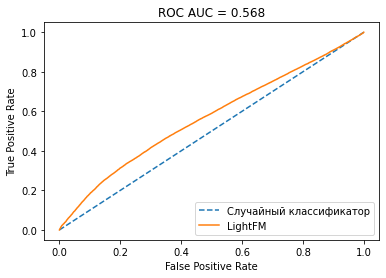

In [48]:
'''
# Модель с оптимизированными гиперпараметрами
train['user_rating'] = train['overall'].apply(lambda x: 1 if x > 3 else 0)
train['verified'] = train['verified'].astype(int)
create_review_tone(train)
create_summary_tone(train)

train_data, test_data = train_test_split(train,random_state=RANDOM_STATE, shuffle=True)

ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

total_users = max(train_data['userid'].max(), test_data['userid'].max()) + 1
total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1

# user_feature
identity_matrix = sparse.identity(total_users)
user_features = sparse.coo_matrix(identity_matrix, train_data[['user_rating', 'verified']])

#item_feature
identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['good_review', 'bad_review', 'good_summary', 'bad_summary']])

model = LightFM(**hyperparams)
# model.fit(train, epochs=num_epochs, num_threads=num_threads)
model = model.fit(ratings_coo, epochs=EPOCHS,
                  user_features=user_features,
                  item_features=item_features,
                  num_threads=NUM_THREADS 
)

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
                    user_features=user_features,
                     item_features=item_features)

show_roc_curve(test_data.rating, preds)
'''

In [49]:
'''
# submission
train_data, test_data = train_test_split(train,random_state=RANDOM_STATE, shuffle=True)
total_users = max(train_data['userid'].max(), test_data['userid'].max()) + 1
total_items = max(train_data['itemid'].max(), test_data['itemid'].max()) + 1

identity_matrix = sparse.identity(total_users)
user_features = sparse.coo_matrix(identity_matrix, train_data[['user_rating', 'verified']])

identity_matrix = sparse.identity(total_items)
item_features = sparse.coo_matrix(identity_matrix, train_data[['good_review', 'bad_review', 'good_summary', 'bad_summary']])
 
preds = model.predict(test.userid.values,
                      test.itemid.values,
                    user_features=user_features,
                     item_features=item_features)
put_submission(preds)
'''

,Id,rating
0,0,0.711421
1,1,0.697404
2,2,0.687761
3,3,0.706137
4,4,0.753473
...,...,...
285960,285960,0.683766
285961,285961,0.727941
285962,285962,0.722000
285963,285963,0.715195


submission roc_auc 0.56745. Немного лучше, чем без features. Но в целом оптимизация гиперпараметров оказалась непродуктивной.
Это уже не первый раз. Видимо, не хватает опыта работы по оптимизации гиперпараметров. Можно предположить, что оптимизация выдает локальный экстремум, либо не успевает завершить поиск экстремума. Здесь есть задел для дальнейшего исследования.